# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 


**Harvard University**<br/>
**Spring 2019**<br/>
**Instructors**: Mark Glickman and Pavlos Protopapas 


<hr style="height:2pt">

<h1> Algorithmic Biases in Facial Recognition </h1>

<h4> Group 43: Whitney Jablonski, Paul Jureidini, Samata Kurhekar, Shourya Veeraganti</h4>

<h3> SUMMARY </h3> <br>
Facial recognition software reports much higher prediction error rates detecting African female faces than Caucasian male faces because of imbalance representation of different races in the dataset. In our work, we are evaluate racial algorithmic bias from a gender prediction perspective. 
<br>
<br>
UTKFace dataset is a large-scale face dataset with long age span (range from 0 to 116 years old). The dataset consists of over 20,000 face images with annotations of age, gender, and ethnicity. The images cover large variation in pose, facial expression, illumination, occlusion, resolution, etc. This dataset could be used on a variety of tasks, e.g., face detection, age estimation, age progression/regression, landmark localization. We used techniques like oversampling with data augmentation and downsampling to reduce bias in gender prediction by race. Evaluated prediction results using classification reports, confusion matrices, visualization of images by race and cross tab of accuracies. 



We also tested our best model on VGG Face2 data which is unseen by the model.  More on results and conclusion.

In [1]:
# import libraries and packages
import numpy as np
import pandas as pd
import os
import uuid
import random

# plotting packages
import matplotlib.pyplot as plt
import seaborn as sns
#from vis.visualization import visualize_saliency
#from vis.utils import utils
import matplotlib.gridspec as gridspec

# image processing packages
from imutils.face_utils import FaceAligner
from imutils.face_utils import rect_to_bb
from skimage.io import imread
import argparse
import imutils
import dlib
import sys
import cv2
import glob
from PIL import Image
from imgaug import augmenters as iaa

#sklearn modeling packages
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# keras for deep neural networks
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, load_model
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalMaxPool2D, Dropout
from keras.optimizers import SGD
from keras import backend as k
from keras import activations
from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
# DATA_PATH = "/jupyteruser/41400447/Project/UTKFace"
# WEIGHTS_PATH = '/jupyteruser/11332722/final_project/weights'
import os
os.getcwd()

'/jupyteruser/41320362/Algorithmic-Biases-in-Facial-Recognition'

#### Constants

In [3]:
'''Constants used in the notebook'''

DATA_PATH = "../data/UTKFace"
WEIGHTS_PATH = "train_weight"
IM_HEIGHT = IM_WIDTH = 198
ID_GENDER_MAP = {0: 'Male', 1: 'Female'}
GENDER_ID_MAP = dict((g, i) for i, g in ID_GENDER_MAP.items())
ID_RACE_MAP = {0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Others'}
RACE_ID_MAP = dict((r, i) for i, r in ID_RACE_MAP.items())

**Upload labels to a dataframe**

In [4]:
'''Extract filenames from the filepath in labels'''

def parse_filepath(filepath):
    try:
        path, filename = os.path.split(filepath)
        filename, ext = os.path.splitext(filename)
        age, gender, race, _ = filename.split("_")
        return int(age), ID_GENDER_MAP[int(gender)], ID_RACE_MAP[int(race)]
    except Exception as e:
        #print(filepath)
        return None, None, None

def list_files(dir):
    r = []
    for root, dirs, files in os.walk(dir):
        for name in files:
            r.append(os.path.join(root, name))
    return r

files = list_files(DATA_PATH)

In [5]:
attributes = list(map(parse_filepath, files))  # obtain all image attributes from image labels

In [6]:
df = pd.DataFrame(attributes)
df['file'] = files
df.columns = ['age', 'gender', 'race', 'file']
df = df.dropna()
df = df.drop_duplicates()
df.head()  #dataframe with all available image labels

,age,gender,race,file
0,82.0,Male,Asian,../data/UTKFace/82_0_2_20170111210110290.jpg.c...
1,32.0,Female,Asian,../data/UTKFace/32_1_2_20170116180211518.jpg.c...
2,21.0,Male,Others,../data/UTKFace/21_0_4_20170103225103768.jpg.c...
3,27.0,Female,Asian,../data/UTKFace/27_1_2_20170116171716287.jpg.c...
4,26.0,Male,Others,../data/UTKFace/26_0_4_20170117153355923.jpg.c...


# Exploratory Analysis

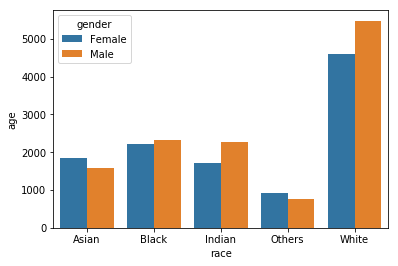

In [7]:
x = pd.DataFrame(df.groupby(by=['race', 'gender'])['age'].count())
x.reset_index(inplace=True)
ax = sns.barplot(x="race", y="age", hue="gender", data=x)

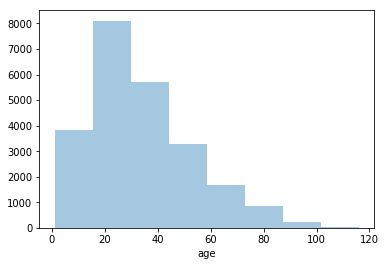

In [8]:
sns.distplot(df['age'], bins = 8, kde=False);

## Preprocessing
### Create Baseline Dataset

First we remove ages that are likely to make gender identification challenging.

In [9]:
df = df[(df['age'] > 10) & (df['age'] < 65)]

Let's revisit the EDA using the baseline dataset.  This dataset ("df") will be used for our baseline model.

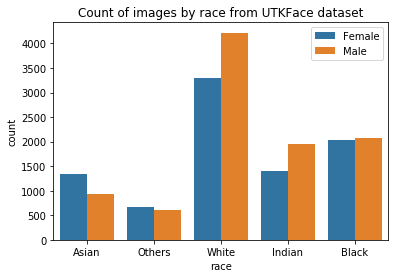

In [10]:
lst_order = ['White', 'Black', 'Asian', 'Indian', 'Others']
ax = sns.countplot(x="race", hue="gender", data=df)
plt.title('Count of images by race from UTKFace dataset')
plt.legend();

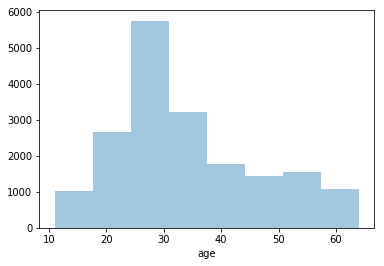

In [11]:
sns.distplot(df['age'], bins = 8, kde=False);

### Create Ethnically Balanced Dataset (skip this part for now)

The baseline dataset contain 18,529 images (see below).

In [12]:
base_len = len(df)
print('Baseline dataset length:{0}'.format(base_len))

Baseline dataset length:18529


There are 10 gender-ethnicity combinations. Let's create a balanced data set similar in size to the baseline dataset, but with equally distributed gender-ethniticy combinations each containing 1,852 images (see below).

In [13]:
bal_subgrp_len = base_len // 10
print('Balanced subgroup length:{0}'.format(bal_subgrp_len))

Balanced subgroup length:1852


To achive this, we will randomly downsample subgroups with more than 1,852 images, and upsample subgroups with fewer than 1,852 images.

Let's revisit the EDA using the balanced dataset ("df_bal").

-----need to add  more here----

# Custom Train Val Test Split Function

In [14]:
'''Train_val_test_split function: to split the dataset into train, validation and test datasets. 

We chose a test_size of 10% and validation_size of 30%.
We stratified on gender and race to have uniform representation of gender and race in train, validation and test datasets
'''
def train_val_test_split(df, test_size, val_size, random_state):
    model_df , test_df = train_test_split(df, test_size = test_size, shuffle = True , random_state = random_state,
                                                  stratify = df[['gender','race']])
    train_df , val_df = train_test_split(model_df, test_size = val_size, shuffle = True , random_state = random_state,
                                                  stratify = model_df[['gender','race']])
    return train_df, val_df, test_df

In [15]:
train_df, val_df, test_df = train_val_test_split(df=df, test_size=0.1, val_size=0.3, random_state=44)

print("Number of samples in train_df: ", train_df.shape[0], "\n",
      "Number of samples in val_df: ", val_df.shape[0], "\n",
      "Number of samples in test_df: ", test_df.shape[0])

('Number of samples in train_df: ', 11673, '\n', 'Number of samples in val_df: ', 5003, '\n', 'Number of samples in test_df: ', 1853)


# Custom Generator Function

In [16]:
'''Custom Generator Function: to get batches of input and corresponding output on the fly during training process.
input : input_path -> image and label
pre-process input : image -> pre-processing step -> image
generator output : batch_images, batch_labels
'''

# PRE-PROCESSING
# function to add noise to input images
def add_noise(input_img):
    aug = iaa.CoarseDropout(0.04, size_percent=0.7, per_channel=0.7)
    seq_object = iaa.Sequential([aug])
    return seq_object.augment_images(input_img)
    
# function to flip and add noise input images from left to right
def flip_noise_img(input_img):
    aug = iaa.CoarseDropout(0.03, size_percent=0.8, per_channel=0.7)
    seq_object = iaa.Sequential([aug])
    im = seq_object.augment_images(input_img)
    return np.fliplr(im)

# custom data generator to get batches of input images for processing with option of whether or not to augment images
def get_data_generator(df, for_training=True, batch_size=16, flip_add_noise=False):
    images, ages, races, genders, files = [], [], [], [], []
    
    while True:
        for i, r in df.iterrows():
            file, age, race, gender = r['file'], r['age'], r['race'], r['gender']
            
            # image preprocessing
            im = Image.open(file)
            im = im.resize((IM_WIDTH, IM_HEIGHT))
            
            #Flipping and adding noise to random images
            if flip_add_noise == True:
                if r['smpl_flg'] == 1 :
                    im=np.array(im)
                    y=np.random.binomial(1, .5)
                    if y==1 :
                        im=add_noise(im)
                    else:
                        im=flip_noise_img(im)
                
            im = np.array(im) / 255.0
            images.append(im)
            
            ages.append(age)
            races.append(race)
            gender_id = GENDER_ID_MAP[gender]
            genders.append(to_categorical(gender_id, 2))
            files.append(file)
            if len(images) >= batch_size:
                if for_training:
                    yield np.array(images), np.array(genders)
                else:
                     yield np.array(images), np.array(genders), np.array(races), np.array(ages), np.array(files)
                images, ages, races, genders, files = [], [], [], [], []
        if not for_training:
            break

# Model

In [17]:
'''MODEL: Functional model is built using keras layers
Layers: Conv2D, Dense, BatchNormalization, Dropout, MaxPool2D and GlobalMaxPool2D
Activation Function: ReLu and softmax
Kernel size: 3
'''

def define_model():
    k.clear_session()  # clear session
    
    def conv_block(inp, filters=32, bn=True, pool=True, drp_out=False):
        _ = Conv2D(filters=filters, kernel_size=3, activation='relu')(inp)

        if drp_out :
            _ = Dropout(0.3)(_)
        if bn:
            _ = BatchNormalization()(_)
        if pool:
            _ = MaxPool2D()(_)
        return _

    input_layer = Input(shape= (IM_HEIGHT, IM_WIDTH, 3))
    _ = conv_block(input_layer, filters=16, bn=False, pool=False)
    _ = conv_block(_, filters=16*2)
    _ = conv_block(_, filters=16*3, drp_out=True)
    _ = conv_block(_, filters=16*4)
    _ = conv_block(_, filters=16*5, drp_out=True)
    #_ = conv_block(_, filters=32*6)
    bottleneck = GlobalMaxPool2D()(_)

    # for gender prediction
    _ = Dense(units=128, activation='relu')(bottleneck)
    gender_output = Dense(units=2, activation='softmax', name='gender_output')(_)
    model = Model(inputs=input_layer, outputs=[gender_output])
    return model

In [18]:
model = define_model()
model.compile(optimizer='rmsprop', 
              loss={'gender_output': 'categorical_crossentropy'},
              metrics={'gender_output': 'accuracy'})
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 198, 198, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 196, 196, 16)      448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 194, 194, 32)      4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 194, 194, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 97, 97, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 95, 95, 48)        13872     
_________________________________________________________________
dropout_1 (Dropout)          (None, 95, 95, 48)        0         
__________

# Model 1: Baseline Run

In [19]:
# Hyperparameters used for model training and saving the model
run_type = 'baseline'
epochs = 10

batch_size = 64
valid_batch_size = 64

# train and validation generator to obtain images
train_gen = get_data_generator(train_df, for_training=True, batch_size=batch_size)
valid_gen = get_data_generator(val_df, for_training=True, batch_size=valid_batch_size)

# adding model checkpoint using keras callbacks function
callbacks = [ModelCheckpoint("./model_checkpoint", monitor='val_loss')]

history = model.fit_generator(train_gen,
                    steps_per_epoch=len(train_df)//batch_size,
                    epochs=epochs,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(val_df)//valid_batch_size)
                    

Epoch 1/10
182/182 [==============================] - 65s 358ms/step - loss: 0.6777 - acc: 0.6759 - val_loss: 0.4973 - val_acc: 0.7829
Epoch 2/10
182/182 [==============================] - 62s 338ms/step - loss: 0.4141 - acc: 0.8128 - val_loss: 0.3543 - val_acc: 0.8776
Epoch 3/10
182/182 [==============================] - 62s 339ms/step - loss: 0.3377 - acc: 0.8589 - val_loss: 0.3807 - val_acc: 0.8626
Epoch 4/10
182/182 [==============================] - 62s 340ms/step - loss: 0.2983 - acc: 0.8783 - val_loss: 0.3289 - val_acc: 0.8670
Epoch 5/10
182/182 [==============================] - 62s 339ms/step - loss: 0.2631 - acc: 0.8923 - val_loss: 0.3109 - val_acc: 0.8902
Epoch 6/10
182/182 [==============================] - 62s 341ms/step - loss: 0.2444 - acc: 0.9016 - val_loss: 0.2603 - val_acc: 0.9171
Epoch 7/10
182/182 [==============================] - 62s 340ms/step - loss: 0.2333 - acc: 0.9065 - val_loss: 0.2643 - val_acc: 0.9125
Epoch 8/10
182/182 [==============================] - 6

In [21]:
'''SAVE and LOAD model and model weights'''

def save_model_weights(model):
    #WEIGHTS_PATH = '/jupyteruser/31376238/final_model/'
    WEIGHTS_PATH = 'train_weight/'
    model.save_weights(WEIGHTS_PATH + '/' + run_type + '_' + str(epochs) + '_epochs.w')
    model.save(WEIGHTS_PATH + '/' + run_type + '_' + str(epochs) + '_original_model.h5')

save_model_weights(model)

In [22]:
'''VALIDATE model on TEST dataset'''

def validate_model(test_df, vmodel, vm_batch_size=109):
    STEP_SIZE_TEST = (test_df.shape[0]//vm_batch_size)-1   # we subtract one, since we took a batch before the loop starts; batch_size=109
    test_gen = get_data_generator(test_df, for_training=False, batch_size=vm_batch_size)
    test_imgs, gender_true, races, ages, file = next(test_gen)

    i=0
    while i< (STEP_SIZE_TEST):   #n-1 since the loop starts from 0
        ti, gt, rt, at, fp = next(test_gen)
        test_imgs = np.append(test_imgs, ti, axis=0)
        races = np.append(races, rt, axis=0)
        gender_true = np.append(gender_true, gt, axis=0)
        ages = np.append(ages, at, axis=0)
        file = np.append(file, fp, axis=0)
        i+=1

    gender_true = gender_true.argmax(axis=-1)

    gender_pred = vmodel.predict(test_imgs)
    gender_pred = gender_pred.argmax(axis=-1)

    cols = {'age':ages, 'race': races, 'gender_true': gender_true, 
           'gender_pred':gender_pred, 'file':file}
    df_preds = pd.DataFrame(data=cols)
    return test_imgs, df_preds

test_imgs, df_preds = validate_model(test_df, model, vm_batch_size=109)
df_preds.head()

,age,file,gender_pred,gender_true,race
0,45.0,../data/UTKFace/45_0_0_20170117192031378.jpg.c...,0,0,White
1,12.0,../data/UTKFace/12_1_2_20170117145333545.jpg.c...,1,1,Asian
2,23.0,../data/UTKFace/23_1_2_20170116173253789.jpg.c...,1,1,Asian
3,36.0,../data/UTKFace/36_0_3_20170119201741572.jpg.c...,0,0,Indian
4,20.0,../data/UTKFace/20_1_0_20170109212842300.jpg.c...,1,1,White


In [23]:
class color:
   BROWN = '\033[91m'
   GREEN = '\033[92m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [24]:
def classification_report_for_model(df_preds):
    unique_races = df_preds['race'].unique()

    for race in unique_races: 
        print(color.BOLD + color.BROWN + "Classification report for race " + race.upper() + color.END, "\n",)
        print(classification_report(df_preds[df_preds['race'] == race]['gender_true'], 
                                    df_preds[df_preds['race'] == race]['gender_pred']))

classification_report_for_model(df_preds)

('\x1b\x1bClassification report for race WHITE\x1b', '\n')
              precision    recall  f1-score   support

           0       0.95      0.83      0.89       422
           1       0.81      0.94      0.87       329

   micro avg       0.88      0.88      0.88       751
   macro avg       0.88      0.89      0.88       751
weighted avg       0.89      0.88      0.88       751

('\x1b\x1bClassification report for race ASIAN\x1b', '\n')
              precision    recall  f1-score   support

           0       0.95      0.87      0.91        93
           1       0.92      0.97      0.94       135

   micro avg       0.93      0.93      0.93       228
   macro avg       0.93      0.92      0.93       228
weighted avg       0.93      0.93      0.93       228

('\x1b\x1bClassification report for race INDIAN\x1b', '\n')
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       194
           1       0.93      0.94      0.93       140

   m

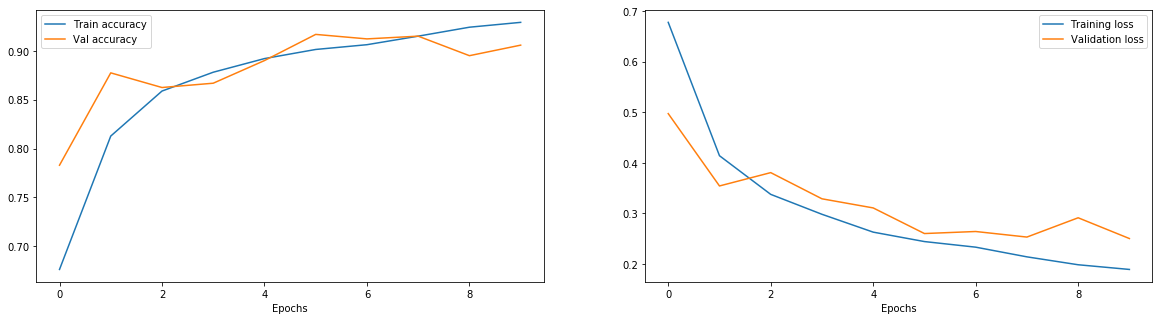

In [25]:
def  plot_train_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))
    
    axes[0].plot(history.history['acc'], label='Train accuracy')
    axes[0].plot(history.history['val_acc'], label='Val accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].legend()

    axes[1].plot(history.history['loss'], label='Training loss')
    axes[1].plot(history.history['val_loss'], label='Validation loss')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()

plot_train_history(history)

In [30]:
def gen_result_sumaries(df):
    df_1 = df.groupby(['gender_true_alpha']).agg({'gender_match': 'mean', 'file':'size'})
    df_1.reset_index(inplace=True)
    df_1.columns=('gender','accuracy','file_count')
    df_1.accuracy = df_1.accuracy * 100
    df_1 = df_1.round({'accuracy': 1})
    df_1.accuracy = df_1.accuracy.astype(str)+'%'
    df_1.file_count = df_1.file_count.astype(str)
    df_1 = df_1.set_index('gender',drop=True)
    df_1

    df_2 = df.groupby(['gender_true_alpha','race']).agg({'gender_match': 'mean', 'file':'size'})
    df_2.reset_index(inplace=True)
    df_2.columns=('gender','race','accuracy','file_count')
    df_2.accuracy = df_2.accuracy * 100
    df_2 = df_2.round({'accuracy': 1})
    df_2.accuracy = df_2.accuracy.astype(str)+'%'
    df_2.file_count = df_2.file_count.astype(str)
    df_2 = df_2.pivot(index='race', columns='gender', values=['accuracy','file_count'])
    df_2.columns = df_2.columns.swaplevel(0,1)
    df_2.sortlevel(0, axis=1, inplace=True)
    df_2

    df_3 = df.groupby(['gender_true_alpha','age_bin']).agg({'gender_match': 'mean', 'file':'size'})
    df_3.reset_index(inplace=True)
    df_3.columns=('gender','age_bin','accuracy','file_count')
    df_3.accuracy = df_3.accuracy * 100
    df_3 = df_3.round({'accuracy': 1})
    df_3.accuracy = df_3.accuracy.astype(str)+'%'
    df_3.file_count = df_3.file_count.astype(str)
    df_3 = df_3.pivot(index='age_bin', columns='gender', values=['accuracy','file_count'])
    df_3.columns = df_3.columns.swaplevel(0,1)
    df_3.sortlevel(0, axis=1, inplace=True)
    df_3
    return df_1, df_2, df_3

'''Table with predicton accuracies for gender and race combinations'''
print(df_preds.head())
df_preds = df_preds.rename(columns={'gender_true':'gender_true_alpha'})
df_1, df_2, df_3 = gen_result_sumaries(df_preds)

print("Prediction summaries for Baseline Model")
display(df_1, df_2, df_3)

    age                                               file  gender_pred  \
0  45.0  ../data/UTKFace/45_0_0_20170117192031378.jpg.c...            0   
1  12.0  ../data/UTKFace/12_1_2_20170117145333545.jpg.c...            1   
2  23.0  ../data/UTKFace/23_1_2_20170116173253789.jpg.c...            1   
3  36.0  ../data/UTKFace/36_0_3_20170119201741572.jpg.c...            0   
4  20.0  ../data/UTKFace/20_1_0_20170109212842300.jpg.c...            1   

   gender_true_alpha    race  
0                  0   White  
1                  1   Asian  
2                  1   Asian  
3                  0  Indian  
4                  1   White  


KeyError: 'gender_match'

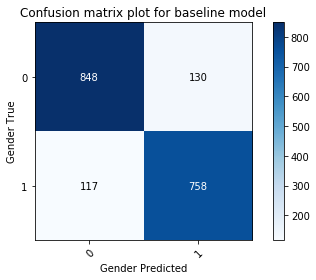

In [42]:
'''CONFUSION MATRIX PLOT'''

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
#     """
#     This function prints and plots the confusion matrix.
#     Normalization can be applied by setting `normalize=True`.
#     """
#     if not title:
#         if normalize:
#             title = 'Normalized confusion matrix'
#         else:
#             title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Gender True',
           xlabel='Gender Predicted')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

plot_confusion_matrix(df_preds['gender_true'], df_preds['gender_pred'], classes=df_preds.gender_true.unique(), 
                      title="Confusion matrix plot for baseline model");

In [ ]:
import math
n = 30
random_indices = np.random.permutation(n)
n_cols = 5
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))
for i, img_idx in enumerate(random_indices):
    ax = axes.flat[i]
    ax.imshow(test_imgs[img_idx])
    ax.set_title('pred:{}'.format(ID_GENDER_MAP[df_preds.gender_pred[img_idx]]))
    ax.set_xlabel('true:{}, race:{}'.format(ID_GENDER_MAP[df_preds.gender_true[img_idx]], df_preds.race[img_idx]))
    ax.set_xticks([])
    ax.set_yticks([])

In [ ]:
import warnings
warnings.filterwarnings("ignore")

fig, big_axes = plt.subplots( figsize=(10.0, 12.0) , nrows=5, ncols=1, sharey=True, constrained_layout=True) 
#fig.suptitle('Gender Prediction by Race', fontsize=20, y=1.05)

for row, big_ax in enumerate(big_axes):
    big_ax.axis('off')
    #big_ax.set_title("Race : %s" %ID_RACE_MAP[row], fontsize=16)
    #big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
    #big_ax._frameon = False
    

for i in range(1,26):
    ax = fig.add_subplot(5,5,i)
    key = int((i-1)/5)
    race_df = df_preds[df_preds['race']==ID_RACE_MAP[key]]
    random_img = np.random.choice(race_df.index)
    img = plt.imread(race_df['file'].loc[random_img]);a
    ax.imshow(img)
    ax.set_title("subplot: %s" %key)
    ax.set_title('Predicted:{}'.format(ID_GENDER_MAP[race_df['gender_pred'].loc[random_img]]))
    ax.set_xlabel('Actual:{}'.format(ID_GENDER_MAP[race_df['gender_true'].loc[random_img]]))
    if i in [1,6,11,16,21]:
        ax.set_ylabel('{}'.format(ID_RACE_MAP[key]), fontsize=20)
    ax.set_xticks([])
    ax.set_yticks([])

fig.set_facecolor('w')
plt.tight_layout()
plt.show()

## Model 2: Downsampling

In [31]:
#Down data to balance the data set
def downsample(base_df,univ_df,race):
    n=univ_df.loc[df.race=='Others'].shape[0]   
    temp=univ_df.loc[df.race==race]
    smpl=temp.sample(n,replace=False)
    df1=base_df.append(smpl)    
    return df1

base_down=train_df.append(val_df)
df_down=base_down.loc[base_down.race=='Others']
df_down=downsample(df_down,base_down,'Black',)
df_down=downsample(df_down,base_down,'Indian')
df_down=downsample(df_down,base_down,'Asian')
df_down=downsample(df_down,base_down,'White')

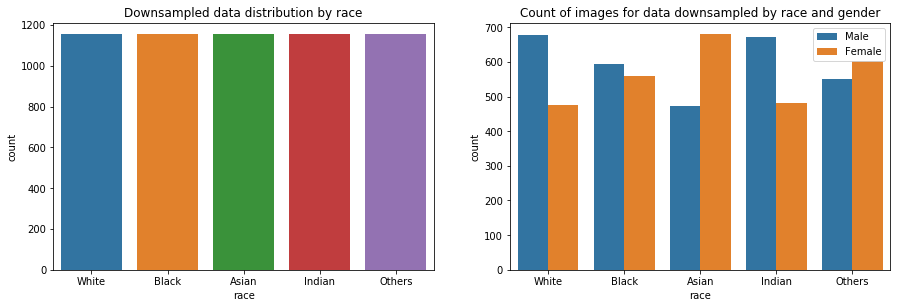

In [32]:
lst_order = ['White', 'Black', 'Asian', 'Indian', 'Others']
plt.figure(figsize=(15, 10))
ax1 = plt.subplot(221)
sns.countplot(x="race", data=df_down, order=lst_order, ax=ax1)
plt.title('Downsampled data distribution by race')
ax2 = plt.subplot(222)
sns.countplot(x="race", hue="gender", data=df_down, order=lst_order, ax=ax2)
plt.title('Count of images for data downsampled by race and gender')
plt.legend();

In [33]:
train_down, val_down = train_test_split(df_down, shuffle = True , test_size=0.1, random_state=44, stratify = df_down[['gender']])

In [34]:
model_dsmpl = define_model()

In [35]:
# invoke the model and compile to save results to variable 'model_dsmpl'
model_dsmpl.compile(optimizer='rmsprop', 
              loss={'gender_output': 'categorical_crossentropy'},
              metrics={'gender_output': 'accuracy'})

In [36]:
# Hyperparameters used for model training and saving the model
run_type = 'downsampling'
epochs = 10

batch_size = 64
valid_batch_size = 64
train_gen = get_data_generator(train_down, for_training=True, batch_size=batch_size, flip_add_noise=False)
valid_gen = get_data_generator(val_down, for_training=True, batch_size=valid_batch_size)

callbacks = [ModelCheckpoint("./model_checkpoint", monitor='val_loss')]

dsmpl_history = model_dsmpl.fit_generator(train_gen,
                    steps_per_epoch=len(train_down)//batch_size,
                    epochs=epochs,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(val_down)//valid_batch_size)
                    

Epoch 1/10
81/81 [==============================] - 26s 318ms/step - loss: 0.7667 - acc: 0.6653 - val_loss: 0.5467 - val_acc: 0.7066
Epoch 2/10
81/81 [==============================] - 24s 302ms/step - loss: 0.5104 - acc: 0.7571 - val_loss: 0.6819 - val_acc: 0.6285
Epoch 3/10
81/81 [==============================] - 25s 303ms/step - loss: 0.4228 - acc: 0.8119 - val_loss: 0.5662 - val_acc: 0.6736
Epoch 4/10
81/81 [==============================] - 25s 304ms/step - loss: 0.3791 - acc: 0.8339 - val_loss: 0.4328 - val_acc: 0.8229
Epoch 5/10
81/81 [==============================] - 25s 304ms/step - loss: 0.3368 - acc: 0.8601 - val_loss: 0.3891 - val_acc: 0.8507
Epoch 6/10
81/81 [==============================] - 25s 304ms/step - loss: 0.3143 - acc: 0.8702 - val_loss: 0.4008 - val_acc: 0.8420
Epoch 7/10
81/81 [==============================] - 25s 305ms/step - loss: 0.2938 - acc: 0.8831 - val_loss: 0.3703 - val_acc: 0.8594
Epoch 8/10
81/81 [==============================] - 25s 304ms/step - 

In [37]:
save_model_weights(model_dsmpl)

In [38]:
test_imgs, df_preds = validate_model(test_df, model_dsmpl, vm_batch_size=109)
df_preds.head()

,age,file,gender_pred,gender_true,race
0,45.0,../data/UTKFace/45_0_0_20170117192031378.jpg.c...,0,0,White
1,12.0,../data/UTKFace/12_1_2_20170117145333545.jpg.c...,1,1,Asian
2,23.0,../data/UTKFace/23_1_2_20170116173253789.jpg.c...,1,1,Asian
3,36.0,../data/UTKFace/36_0_3_20170119201741572.jpg.c...,0,0,Indian
4,20.0,../data/UTKFace/20_1_0_20170109212842300.jpg.c...,1,1,White


In [39]:
classification_report_for_model(df_preds)

('\x1b\x1bClassification report for race WHITE\x1b', '\n')
              precision    recall  f1-score   support

           0       0.90      0.85      0.87       422
           1       0.82      0.87      0.85       329

   micro avg       0.86      0.86      0.86       751
   macro avg       0.86      0.86      0.86       751
weighted avg       0.86      0.86      0.86       751

('\x1b\x1bClassification report for race ASIAN\x1b', '\n')
              precision    recall  f1-score   support

           0       0.85      0.91      0.88        93
           1       0.94      0.89      0.91       135

   micro avg       0.90      0.90      0.90       228
   macro avg       0.89      0.90      0.90       228
weighted avg       0.90      0.90      0.90       228

('\x1b\x1bClassification report for race INDIAN\x1b', '\n')
              precision    recall  f1-score   support

           0       0.91      0.92      0.92       194
           1       0.89      0.88      0.88       140

   m

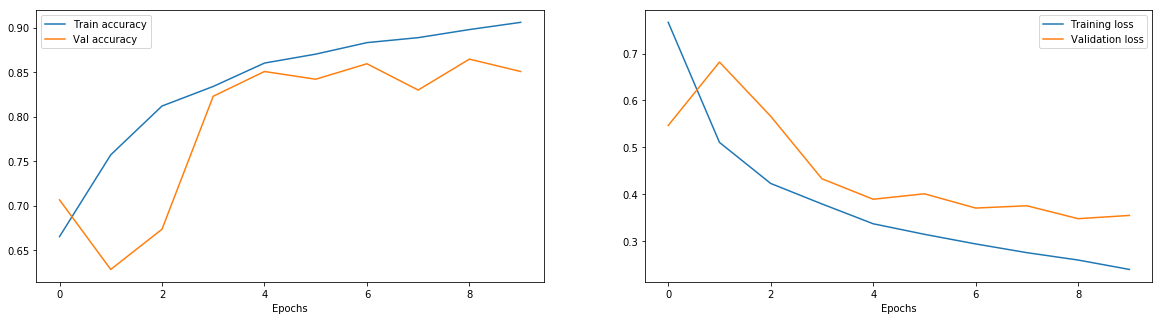

In [40]:
plot_train_history(dsmpl_history)

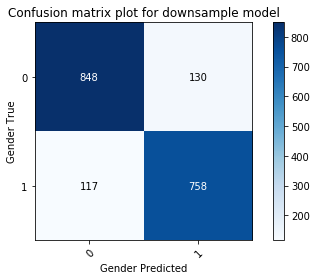

In [43]:
plot_confusion_matrix(df_preds['gender_true'], df_preds['gender_pred'], classes=df_preds.gender_true.unique(), 
                      title="Confusion matrix plot for downsample model");

In [120]:
'''Table with predicton accuracies for gender and race combinations'''
df_1, df_2, df_3 = gen_result_sumaries(df_preds)
print("Prediction summaries for Model with data downsampled")
display(df_1, df_2, df_3)

Prediction summaries for Baseline Model


,accuracy,file_count
gender,,
Female,93.7%,875
Male,82.1%,978


gender   Female                Male           
       accuracy file_count accuracy file_count
race                                          
Asian     95.6%        135    79.6%         93
Black     95.6%        204    80.3%        208
Indian    90.0%        140    83.0%        194
Others    94.0%         67    83.6%         61
White     93.3%        329    82.9%        422

gender     Female                Male           
         accuracy file_count accuracy file_count
age_bin                                         
[10, 20)    87.7%         73    60.0%         60
[20, 35)    94.4%        536    83.1%        396
[35, 50)    94.2%        173    82.7%        284
[50, 66)    93.5%         93    85.3%        238

## Model 3: Oversampling and Data Augmentation

In [44]:
#Upsampling data to balance the data set
import warnings
warnings.filterwarnings('ignore')

def upsample(df,race):
    n=df.loc[df.race=='White'].shape[0]-df.loc[df.race==race].shape[0]
    temp=df.loc[df.race==race]
    smpl=temp.sample(n,replace=True)
    smpl['smpl_flg']=1
    df=df.append(smpl)
    return df

base_up=train_df.append(val_df)

df_up=upsample(base_up,'Black')
df_up=upsample(df_up,'Indian')
df_up=upsample(df_up,'Asian')
df_up=upsample(df_up,'Others')

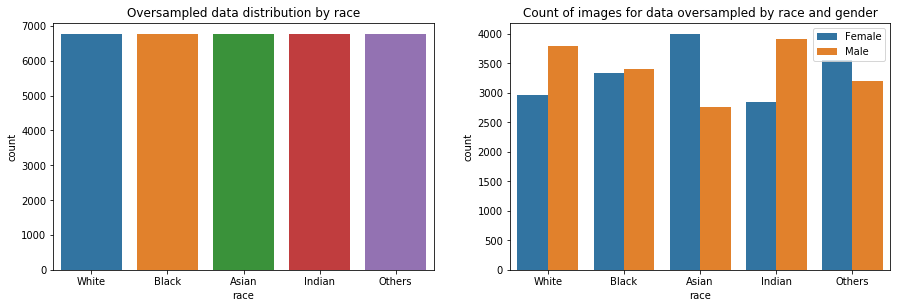

In [45]:
lst_order = ['White', 'Black', 'Asian', 'Indian', 'Others']
plt.figure(figsize=(15, 10))
ax1 = plt.subplot(221)
sns.countplot(x="race", data=df_up, order=lst_order, ax=ax1)
plt.title('Oversampled data distribution by race')
ax2 = plt.subplot(222)
sns.countplot(x="race", hue="gender", data=df_up, order=lst_order, ax=ax2)
plt.title('Count of images for data oversampled by race and gender')
plt.legend();

In [46]:
train_upsmpl, val_upsmpl = train_test_split(df_up, shuffle = True , test_size=0.1, random_state=44, stratify = df_up[['gender']])

In [47]:
model_usmpl = define_model()

model_usmpl.compile(optimizer='rmsprop', 
              loss={'gender_output': 'categorical_crossentropy'},
              metrics={'gender_output': 'accuracy'})

In [48]:
%%time
run_type = 'upsampling'
epochs = 10

batch_size = 64
valid_batch_size = 64
train_gen = get_data_generator(train_upsmpl, for_training=True, batch_size=batch_size, flip_add_noise=True)
valid_gen = get_data_generator(val_upsmpl, for_training=True, batch_size=valid_batch_size, flip_add_noise=True)

callbacks = [ModelCheckpoint("./model_checkpoint", monitor='val_loss')]

usmpl_history = model_usmpl.fit_generator(train_gen,
                    steps_per_epoch=len(train_upsmpl)//batch_size,
                    epochs=epochs,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(val_upsmpl)//valid_batch_size)
                    

Epoch 1/10
474/474 [==============================] - 897s 2s/step - loss: 0.5050 - acc: 0.7793 - val_loss: 0.3780 - val_acc: 0.8413
Epoch 2/10
474/474 [==============================] - 885s 2s/step - loss: 0.2939 - acc: 0.8800 - val_loss: 0.2841 - val_acc: 0.9150
Epoch 3/10
474/474 [==============================] - 878s 2s/step - loss: 0.2449 - acc: 0.9030 - val_loss: 0.2750 - val_acc: 0.9093
Epoch 4/10
474/474 [==============================] - 873s 2s/step - loss: 0.2231 - acc: 0.9142 - val_loss: 0.3119 - val_acc: 0.8921
Epoch 5/10
474/474 [==============================] - 892s 2s/step - loss: 0.1997 - acc: 0.9252 - val_loss: 0.3256 - val_acc: 0.8717
Epoch 6/10
474/474 [==============================] - 882s 2s/step - loss: 0.1868 - acc: 0.9310 - val_loss: 0.2377 - val_acc: 0.9174
Epoch 7/10
474/474 [==============================] - 882s 2s/step - loss: 0.1692 - acc: 0.9391 - val_loss: 0.2123 - val_acc: 0.9246
Epoch 8/10
474/474 [==============================] - 882s 2s/step - 

In [49]:
save_model_weights(model_usmpl)

In [50]:
test_imgs, df_preds = validate_model(test_df, model_usmpl, vm_batch_size=109)
df_preds.head()

,age,file,gender_pred,gender_true,race
0,45.0,../data/UTKFace/45_0_0_20170117192031378.jpg.c...,0,0,White
1,12.0,../data/UTKFace/12_1_2_20170117145333545.jpg.c...,1,1,Asian
2,23.0,../data/UTKFace/23_1_2_20170116173253789.jpg.c...,1,1,Asian
3,36.0,../data/UTKFace/36_0_3_20170119201741572.jpg.c...,0,0,Indian
4,20.0,../data/UTKFace/20_1_0_20170109212842300.jpg.c...,1,1,White


In [51]:
classification_report_for_model(df_preds)

('\x1b\x1bClassification report for race WHITE\x1b', '\n')
              precision    recall  f1-score   support

           0       0.92      0.93      0.93       422
           1       0.91      0.90      0.91       329

   micro avg       0.92      0.92      0.92       751
   macro avg       0.92      0.92      0.92       751
weighted avg       0.92      0.92      0.92       751

('\x1b\x1bClassification report for race ASIAN\x1b', '\n')
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        93
           1       0.95      0.95      0.95       135

   micro avg       0.94      0.94      0.94       228
   macro avg       0.94      0.94      0.94       228
weighted avg       0.94      0.94      0.94       228

('\x1b\x1bClassification report for race INDIAN\x1b', '\n')
              precision    recall  f1-score   support

           0       0.92      0.97      0.95       194
           1       0.96      0.89      0.92       140

   m

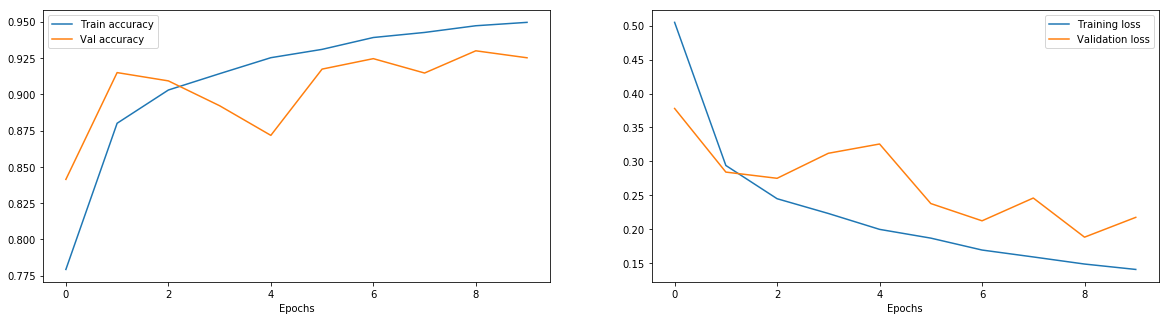

In [52]:
plot_train_history(usmpl_history)

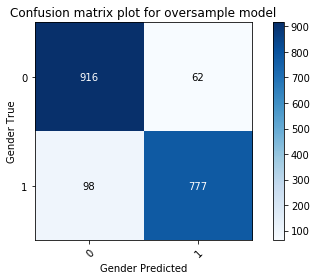

In [53]:
plot_confusion_matrix(df_preds['gender_true'], df_preds['gender_pred'], classes=df_preds.gender_true.unique(), 
                      title="Confusion matrix plot for oversample model");

In [54]:
'''Table with predicton accuracies for gender and race combinations'''
df_1, df_2, df_3 = gen_result_sumaries(df_preds)
print("Prediction summaries for Model with data oversampled")
display(df_1, df_2, df_3)

KeyError: 'gender_true_alpha'

In [ ]:
# Generate a batch of 5 images for augmentated image visualization 
aug_gen = get_data_generator(train_upsmpl, for_training=False, batch_size=5, flip_add_noise=True) #check on the data being passed
aug_imgs, gender_true, races, ages, file = next(aug_gen)


# Plot 
plt.figure(figsize=(8, 6), frameon=False)
plt.suptitle('Image Augmentation', fontsize=15, y=.95)

gs1 = gridspec.GridSpec(2, 5)
gs1.update(hspace=0.05)

for i in range(10):
    #img = test_imgs[i]
    ax = plt.subplot(gs1[i])
    if i < 5:
        ax.imshow(plt.imread(file[i]))
        ax.set_title("original img: %s" %i)
    else : 
        ax.imshow(aug_imgs[i-5])
        ax.set_title("augmented: %s" %(i-5))
   #plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

plt.show()

In [ ]:
# Generate a batch of 5 images for augmentated image visualization 
aug_gen = get_data_generator(train_upsmpl, for_training=False, batch_size=5, flip_add_noise=True) #check on the data being passed
aug_imgs, gender_true, races, ages, file = next(aug_gen)

lst = ['Original image', 'Image Augmented with flip or noise']
fig, big_axes = plt.subplots( figsize=(10,8) , nrows=2, ncols=1, sharey=True) 
fig.suptitle('Image Augmentation', fontsize=15, y=.95)


for row, big_ax in enumerate(big_axes):
    big_ax.set_title("%s \n" %lst[row], fontsize=14, y=.75)
    big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
    big_ax._frameon = False


for i in range(1,11):
    ax = fig.add_subplot(2,5,i)
    #key = int((i-1)/5)
    ax.set_title("subplot: %s" %i)
    if i < 6:
        ax.imshow(plt.imread(file[i-1]))
        ax.set_title("original img: %s" %i)
    else : 
        ax.imshow(aug_imgs[i-6])  
        ax.set_title("augmented : %s" %(i-5))
    #ax.set_title('Predicted:{}'.format(ID_GENDER_MAP[race_df['gender_pred'].loc[random_img]]))
    #ax.set_xlabel('Actual:{}'.format(ID_GENDER_MAP[race_df['gender_true'].loc[random_img]]))
    ax.set_xticks([])
    ax.set_yticks([])
    

fig.set_facecolor('w')
plt.tight_layout()
plt.show()

# Best Model Predictions by Race

**Saliency Map at each layer**

In [55]:
def get_saliency(img, layer_nm='gender_output',model=model_usmpl):
    layer_ind=utils.find_layer_idx(model,layer_nm)
    model.layers[layer_ind].activation = activations.linear
    model = utils.apply_modifications(model)
    grads = visualize_saliency(model, layer_ind, filter_indices=0,  seed_input=img)
    return grads

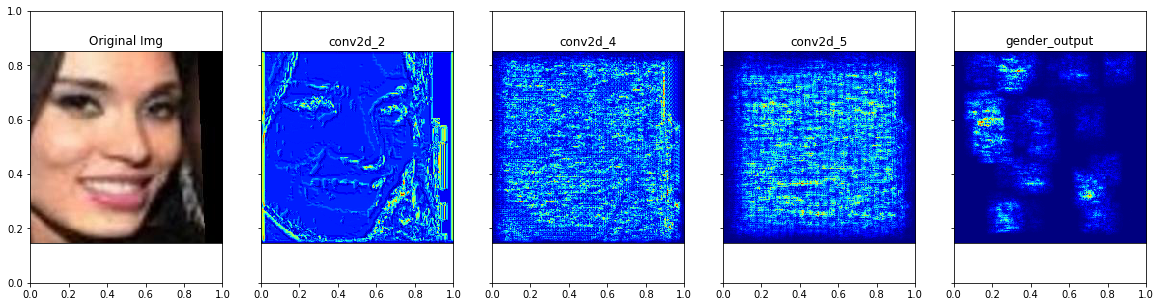

In [88]:
layer_names=['conv2d_2', 'conv2d_4', 'conv2d_5', 'gender_output']

random_img = np.random.choice(df.index)
img = plt.imread(df['file'].loc[random_img]);

fig, big_axes = plt.subplots( nrows=1, ncols=5, sharey=True, figsize=(20,5)) 

for i in range(5) :
    ax=fig.add_subplot(1, 5, i+1)
    if i == 0 :
        ax.imshow(img)
        ax.set_title('Original Img')
        ax.set_xticks([])
        ax.set_yticks([])
       # ax.set_axis_off()
    else:
        sal= get_saliency(img=img, layer_nm=layer_names[i-1],model=model_usmpl)
        ax.imshow(sal, cmap='jet')
        ax.set_title(layer_names[i-1])
        ax.set_xticks([])
        ax.set_yticks([])
  #  ax.set_axis_off()
# plt.xticks([])
# plt.yticks([])
plt.show()

**Saliency Maps by Gender and Race**

In [ ]:
import warnings
warnings.filterwarnings("ignore")

def get_saliency(img=img, layer_nm='gender_output',model=model_usmpl):
    layer_ind=utils.find_layer_idx(model,layer_nm)
    model.layers[layer_ind].activation = activations.linear
    model = utils.apply_modifications(model)
    grads = visualize_saliency(model, layer_ind, filter_indices=0,  seed_input=img)
    return grads


fig, big_axes = plt.subplots( figsize=(10.0, 15.0) , nrows=5, ncols=1, sharey=True) 
fig.suptitle('Saliency Maps by Race and Gender', fontsize=20, y=1.01)

for row, big_ax in enumerate(big_axes):
    big_ax.set_title("Race : %s \n" %ID_RACE_MAP[row], fontsize=16, y=1.05)
    big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
    big_ax._frameon = False

for i in range(1,21,4):
    ax = fig.add_subplot(5,4,i)
    key = int((i-1)/5)
    race_df = df_preds[(df_preds['race']==ID_RACE_MAP[key]) & (df_preds['gender_true']==1) & (df_preds['gender_pred']==1)]
    random_img = np.random.choice(race_df.index)
    img = plt.imread(race_df['file'].loc[random_img]);
    ax.imshow(img)
    ax.set_title("subplot: %s" %key)
    ax.set_title('Female : Org Image')
    ax.set_axis_off()
    ax = fig.add_subplot(5,4,i+1)
    sal= get_saliency(img=img, layer_nm='gender_output',model=model_usmpl)
    ax.imshow(sal, cmap='jet')
    ax.set_title("subplot: %s" %key)
    ax.set_title('Female : SaliencyMap')   
    ax.set_axis_off()

    
for i in range(3,21,4):
    ax = fig.add_subplot(5,4,i)
    key = int((i-1)/5)
    race_df = df_preds[(df_preds['race']==ID_RACE_MAP[key]) & (df_preds['gender_true']==0) & (df_preds['gender_pred']==0)]
    random_img = np.random.choice(race_df.index)
    img = plt.imread(race_df['file'].loc[random_img]);
    ax.imshow(img)
    ax.set_title("subplot: %s" %key)
    ax.set_title('Male: Org Image')
    ax.set_axis_off()
    ax = fig.add_subplot(5,4,i+1)
    sal= get_saliency(img=img, layer_nm='gender_output',model=model_usmpl)
    ax.imshow(sal, cmap='jet')
    ax.set_title("subplot: %s" %key)
    ax.set_title('Male: SaliencyMap')   
    ax.set_axis_off()
plt.tight_layout()

**Prediction accuracies**

**Visualization of images for gender prediction by race**

In [ ]:
import warnings
warnings.filterwarnings("ignore")

fig, big_axes = plt.subplots( figsize=(15.0, 20.0) , nrows=5, ncols=1, sharey=True) 
fig.suptitle('Gender Prediction by Race', fontsize=20, y=1.05)

for row, big_ax in enumerate(big_axes):
    big_ax.set_title("Race : %s \n" %ID_RACE_MAP[row], fontsize=16)
    big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
    big_ax._frameon = False


for i in range(1,26):
    ax = fig.add_subplot(5,5,i)
    key = int((i-1)/5)
    race_df = df_preds[df_preds['race']==ID_RACE_MAP[key]]
    random_img = np.random.choice(race_df.index)
#     img = plt.imread(race_df['file'].loc[random_img]);
#     ax.imshow(img)
    ax.imshow(test_imgs[random_img])
    ax.set_title("subplot: %s" %key)
    ax.set_title('Predicted:{}'.format(ID_GENDER_MAP[race_df['gender_pred'].loc[random_img]]))
    ax.set_xlabel('Actual:{}'.format(ID_GENDER_MAP[race_df['gender_true'].loc[random_img]]))
    ax.set_xticks([])
    ax.set_yticks([])

fig.set_facecolor('w')
plt.tight_layout()
plt.show()

In [ ]:
import warnings
warnings.filterwarnings("ignore")

fig, big_axes = plt.subplots( figsize=(10.0, 12.0) , nrows=5, ncols=1, sharey=True, constrained_layout=True) 
#fig.suptitle('Gender Prediction by Race', fontsize=20, y=1.05)

for row, big_ax in enumerate(big_axes):
    big_ax.axis('off')
    #big_ax.set_title("Race : %s" %ID_RACE_MAP[row], fontsize=16)
    #big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
    #big_ax._frameon = False
    

for i in range(1,26):
    ax = fig.add_subplot(5,5,i)
    key = int((i-1)/5)
    race_df = df_preds[df_preds['race']==ID_RACE_MAP[key]]
    random_img = np.random.choice(race_df.index)
    img = plt.imread(race_df['file'].loc[random_img]);
    ax.imshow(img)
    ax.set_title("subplot: %s" %key)
    ax.set_title('Predicted:{}'.format(ID_GENDER_MAP[race_df['gender_pred'].loc[random_img]]))
    ax.set_xlabel('Actual:{}'.format(ID_GENDER_MAP[race_df['gender_true'].loc[random_img]]))
    if i in [1,6,11,16,21]:
        ax.set_ylabel('{}'.format(ID_RACE_MAP[key]), fontsize=20)
    ax.set_xticks([])
    ax.set_yticks([])

fig.set_facecolor('w')
plt.tight_layout()
plt.show()

**Confusion Matrix of gender predictions by race**

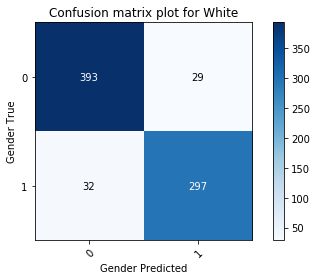

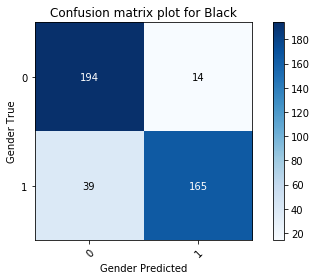

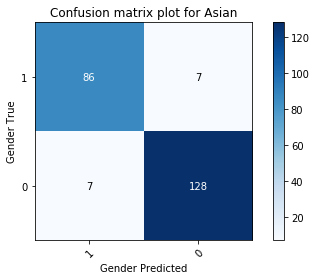

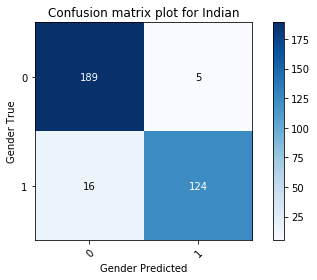

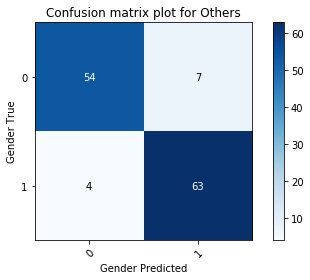

In [57]:
# fig, ax = plt.subplots(3, 2)
for i in range(1, 7):
#     ax = fig.add_subplot(3,2,i)
    if i<=5:
        race_df = df_preds[df_preds['race']==ID_RACE_MAP[i-1]]
        ax = plot_confusion_matrix(race_df['gender_true'], race_df['gender_pred'], classes=race_df.gender_true.unique(), 
                          title="Confusion matrix plot for {}".format(ID_RACE_MAP[i-1]));

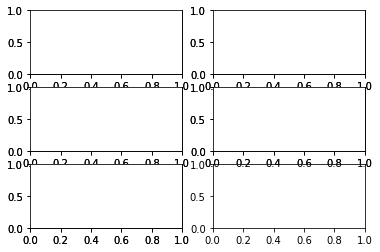

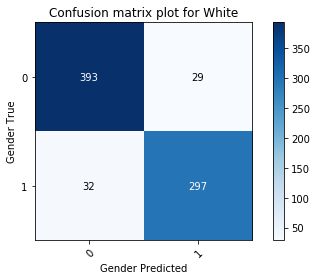

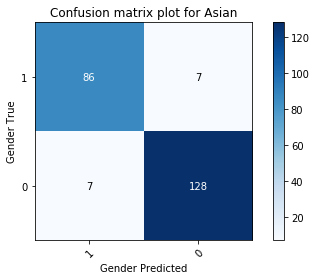

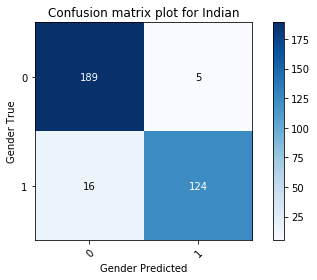

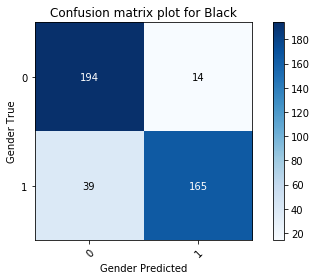

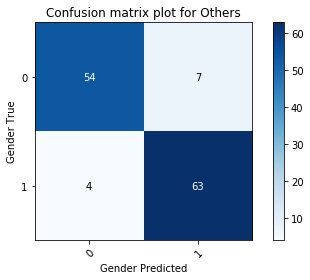

In [60]:
fig, ax = plt.subplots(3, 2)
for i,r in enumerate(df_preds['race'].unique()):
    if i<=5:
        race_df = df_preds[df_preds['race']==r]
        ax = fig.add_subplot(3,2,i+1)
        ax = plot_confusion_matrix(race_df['gender_true'], race_df['gender_pred'], classes=race_df.gender_true.unique(), 
                          title="Confusion matrix plot for {}".format(r));

# Testing Model on VGG Face2 Images

**VGG Face2 dataset sub-sample evaluation on model trained with UTKFace data**

We decided to test our model with a completely new set of images from VGG Face2 dataset. We took a balanced dataset where gender is balanced within each race. Pre-processing of images was done using "dlib" tool on 30 images for 5 races namely, "White", "Black", "Asian", "Indian", "Others". These images were predicted on using model trained on UTKFace data. Results are pretty accurate and aligned with results obtained on prediction with UTKFace Data. Confusion Matrix plot represents the prediction accuracy.

In [ ]:
# Read VGG Face2 Image labels into pandas dataframe
vgg_df = pd.read_csv('/jupyteruser/31376238/all_sample_datasets/vggface2_data_on_utkface_model/sub_sample_identity_meta.csv')
vgg_df.head()

In [ ]:
# construct the argument parser and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-p", "--shape-predictor", required=False,help="path to facial landmark predictor")
ap.add_argument("-i", "--image", required=False,help="path to input image")
args = vars(ap.parse_args('-i image -p shape-predictor'.split()))

# initialize dlib's face detector (HOG-based) and then create
# the facial landmark predictor and the face aligner

detector = dlib.get_frontal_face_detector()

predictor=dlib.shape_predictor("/jupyteruser/31376238/age-gender-race-prediction-master/FaceDetection/shape_predictor_68_face_landmarks.dat")
fa = FaceAligner(predictor, desiredFaceWidth=128)

# load and show the original input image 
img_path = '/jupyteruser/31376238/all_sample_datasets/vggface2_data_on_utkface_model/'
for i, j in vgg_df.iterrows(): 
    img = j['img_file']
    image = imread(img_path + img)
    image = imutils.resize(image, width=200, height = 200)

    #detect faces in the grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    dlib.get_frontal_face_detector()
    rects = detector(gray, 2)
    
    
    # loop over the face detections
    for rect in rects:
        # extract the ROI of the *original* face, then align the face
        # using facial landmarks
        (x, y, w, h) = rect_to_bb(rect)
        faceOrig = imutils.resize(image[y:y + h, x:x + w], width=200)
        faceAligned = fa.align(image, gray, rect)

        f = str(uuid.uuid4())
        cv2.imwrite(img_path+"aligned/" + img , faceAligned)

In [ ]:
VGG_DATA_PATH = "/jupyteruser/31376238/all_sample_datasets/vggface2_data_on_utkface_model/aligned"
files = list_files(VGG_DATA_PATH)
vgg_df['file'] = files[1:]

In [ ]:
vgg_imgs, vgg_preds = validate_model(vgg_df, vm_batch_size=6)
df_preds.head()

In [ ]:
random_sel = np.random.choice(vgg_df.index)
plt.imshow(vgg_imgs[random_sel])
plt.suptitle("Prediction on VGG Face2 dataset", y=1.01)
plt.title('pred:{}'.format(ID_GENDER_MAP[vgg_preds['gender_pred'].loc[random_sel]]));
plt.xlabel('true:{}'.format(ID_GENDER_MAP[vgg_preds['gender_true'].loc[random_sel]]))
plt.xticks([]);
plt.yticks([]);

In [ ]:
class_names = vgg_preds.gender_true.unique()
plot_confusion_matrix(vgg_preds.gender_true, vgg_preds.gender_pred, classes=class_names,
                      title='Confusion matrix for Gender Prediction on VGG Face2 DataSet');

In [ ]:
classification_report_for_model(vgg_preds)

In [123]:
def add_noise(input_img):
    aug = iaa.CoarseDropout(0.04, size_percent=0.7, per_channel=0.7)
    seq_object = iaa.Sequential([aug])
    return seq_object.augment_images(input_img)
    
# function to flip and add noise input images from left to right
def flip_noise_img(input_img):
    aug = iaa.CoarseDropout(0.03, size_percent=0.8, per_channel=0.7)
    seq_object = iaa.Sequential([aug])
    im = seq_object.augment_images(input_img)
    return np.fliplr(im)

6100


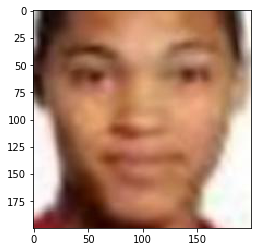

In [128]:
random_sel = np.random.choice(df.index)
img = plt.imread(df['file'].loc[random_sel]);
plt.imshow(img)

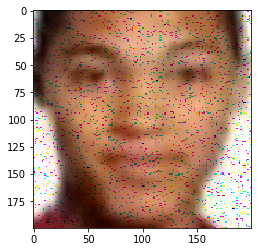

In [129]:
chk = add_noise(img)
plt.imshow(chk)

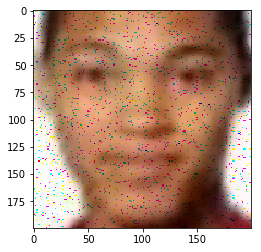

In [130]:
chk = flip_noise_img(img)
plt.imshow(chk)